d:\MiniforgeConda\envs\xxy\lib\site-packages\kwant\lattice.py:751: KwantDeprecationWarning: Not specfying norbs is deprecated. Always specify norbs when creating site families.
  return Monatomic(((a, 0, 0), (0, a, 0), (0, 0, a)),


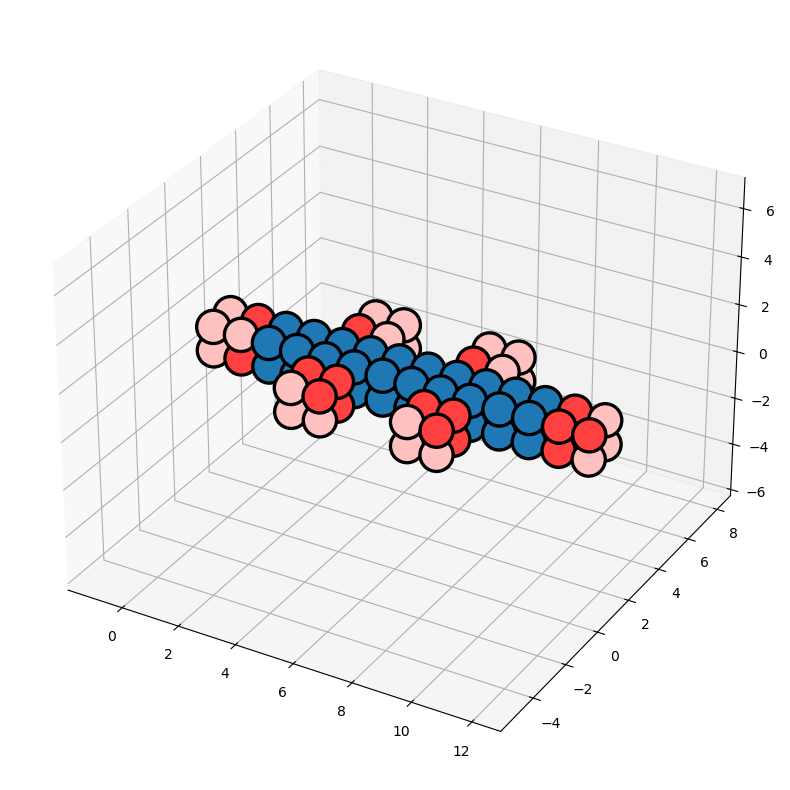

In [6]:
import kwant
import numpy as np
import tinyarray
import matplotlib.pyplot as plt

# Pauli 矩阵和 Γ 矩阵定义（4×4）
sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j,  0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

I_4=tinyarray.array(np.kron(sigma_0, sigma_0))
gamma_1 = tinyarray.array(np.kron(sigma_0, sigma_z))
gamma_2 = tinyarray.array(np.kron(sigma_z, sigma_z))
gamma_3 = tinyarray.array(np.kron(sigma_0, sigma_y))
gamma_4 = tinyarray.array(np.kron(sigma_0, sigma_x))

B = -300
g = 300
las = 1.0  # 晶格常数
width = 30


# 3D 立方晶格
lat = kwant.lattice.cubic(a=las)
# 定义双层模型
def make_syst(m, c,width=20, length=100):

    #EG能
    EG_onsite    = (4*c)/las**2 * I_4
    EG_hopping_x = -c/(las**2)*I_4
    EG_hopping_y = -c/(las**2)*I_4 
    
    #TI能
    onsite    = m / 2 * gamma_1 - (4 * B) / (las ** 2) * gamma_2
    hopping_x = B / (las ** 2) * gamma_2 + 1j * g / (2 * las) * gamma_3
    hopping_y = B / (las ** 2) * gamma_2 - 1j * g / (2 * las) * gamma_4
    hopping_z = 1.0 * I_4


    # 带 3D hopping 的“原胞”函数
    def model():
        structure=kwant.lattice.cubic(las)
        model_sym= kwant.TranslationalSymmetry(structure.vec((1,0,0)),structure.vec((0,-1,0)),structure.vec((0,0,1)))
        model_1= kwant.Builder(model_sym)

        model_1[structure(0,0,0)] = onsite
        model_1[kwant.builder.HoppingKind((1,0,0), structure)]  = hopping_x
        model_1[kwant.builder.HoppingKind((0,1,0), structure)]  = hopping_y
        model_1[kwant.builder.HoppingKind((0,0,1), structure)]  = hopping_z

        return model_1


    # 散射区：x∈[1,length], y∈[1,width], z=0 or 1
    def shape_center(site):
        x, y, z = site.pos
        return (0 < x <= length) and (0 < y <= width) and (0 <= z < 2)

    syst = kwant.Builder()
    syst.fill(model(), shape_center, (1, 1, 0))

    # 引线宽度，沿 x 方向的 leads:
    width_lead = length // 5

    # 定义三个引线，彼此翻转得到 6 个端口
    leads = []
    # lead0：沿 −x 延伸，跨两个层
    lead0 = kwant.Builder(kwant.TranslationalSymmetry((-1, 0, 0)))
    def shape_l0(site):
        x, y, z = site.pos
        return (0 < y <= width) and (0 <= z < 2)
    lead0.fill(model(), shape_l0, (0, 1, 0))
    leads.append(lead0)

    # lead1：沿 +y 延伸，跨两个层
    lead1 = kwant.Builder(kwant.TranslationalSymmetry((0, 1, 0)))
    def shape_l1(site):
        x, y, z = site.pos
        return (width_lead < x <= 2*width_lead) and (0 <= z < 2)
    lead1.fill(model(), shape_l1, (width_lead+1, 0, 0))
    leads.append(lead1)

    # lead2：沿 +y 延伸，不同 x 区间
    lead2 = kwant.Builder(kwant.TranslationalSymmetry((0, 1, 0)))
    def shape_l2(site):
        x, y, z = site.pos
        return (3*width_lead < x <= 4*width_lead) and (0 <= z < 2)
    lead2.fill(model(), shape_l2, (3*width_lead+1, 0, 0))
    leads.append(lead2)

    # attach leads and their reversed copies
    for ld in [leads[0], leads[1], leads[2], leads[0].reversed(), leads[2].reversed(), leads[1].reversed()]:
        syst.attach_lead(ld)

    return syst.finalized()

syst3d = make_syst(m=30,c= 1,width=2, length=10)
fig= kwant.plot(syst3d, fig_size=(10, 10))
plt.show()


